In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd

from utils.dataprep.metadata import *
from utils.dataprep.scores import *
from utils.data import DataManager
from utils.features import *
from utils.statematrix import *
from utils.model import *
from utils.training import *

Using gpu device 0: GeForce GTX 660 (CNMeM is disabled, cuDNN 5105)


In [3]:
DIR = Path('')
DATA_DIR = DIR/'data/'

# Musescore Metadata/Score Retrieval

The first part of any pipeline is to retrieve a dataset. For this we will use the [musescore api](http://developers.musescore.com/) for both the metadata retrieval and the score download.

In [ ]:
# Cleaing of the dataset before retrieval
def metadata_sanetization(df, min_measures=10, max_measures=100):
    df = df[pd.to_numeric(df.id, errors='coerce').notnull()]
    df['metadata_measures'] = pd.to_numeric(df['metadata_measures'], errors='coerce')
    df = df[(df.metadata_measures >= min_measures) & (df.metadata_measures <= max_measures)]
    return df

### 1 Part
We start by retrieving score metadata for score with only one part. When it's done, we start downloading the scores.

In [ ]:
prefix = 'ms_parts_1' 
meta_file = get_metadata(DATA_DIR, prefix, parts=1, retrieve_max=100)
df = metadata_sanetization(pd.read_csv(meta_file))  
df_paths = get_scores(df, DATA_DIR, prefix)

### Part 2

In [ ]:
prefix = 'ms_parts_2' 
meta_file = get_metadata(DATA_DIR, prefix, parts=2, retrieve_max=100) 
df = metadata_sanetization(pd.read_csv(meta_file))  
df_paths = get_scores(df, DATA_DIR, prefix)

# Dataset selection

In [4]:
datamanager = DataManager(FeatureBuilderArticulations(), StateMatrixBuilderArticulations())

In [ ]:
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

In [ ]:
score_paths = listdir_fullpath('data/ms_parts_1') + listdir_fullpath('data/ms_parts_2')

In [ ]:
pieces = datamanager.pieces_to_statematrix(score_paths)
pickle.dump(pieces, open('data/music_statematrix.pkl', 'wb'))

# Training

We will first create a "data manager", this object will be used as a wrapper around the two builder needed by the model. The feature builder is in charge of going from input space to feature space. The statematrix builder is in charge of going from the "score" space (the raw data in xml/kern/etc.) to input space and vice versa.

In [5]:
model = Model(datamanager, [300,300],[100,50], dropout=0.5)
model.setup()

Initializing Model       Done
Setup Train              Done
Setup Generate           Done


If you have already trained weights run the following cell.

In [ ]:
# Use this if loading GPU params to CPU model.
# import thenao
# thenao.config.experimental.unpickle_gpu_on_cpu = True

config = pickle.load(open("output/weights/params_final.p", "rb" ))
model.learned_config = config

In [7]:
# Load the pieces in statematrix format
pieces = pickle.load(open("data/music_statematrix.pkl", "rb" ))

The training is quiet slow. It takes ~10 secondes on a GTX 650 per iteration.

In [9]:
print("Training")
train_piece(model, pieces, 10, 'output/')

print("Dumping")
pickle.dump(model.learned_config, open( "output/weights/final_learned_config.p", "wb" ) )


  0%|          | 0/10 [00:00<?, ?it/s]

Training


epoch     0,  error 28062.4609,  validation 12004.6159
epoch     0,  generating



100%|██████████| 10/10 [03:38<00:00, 14.81s/it]

Finish Training
Dumping


# Generating

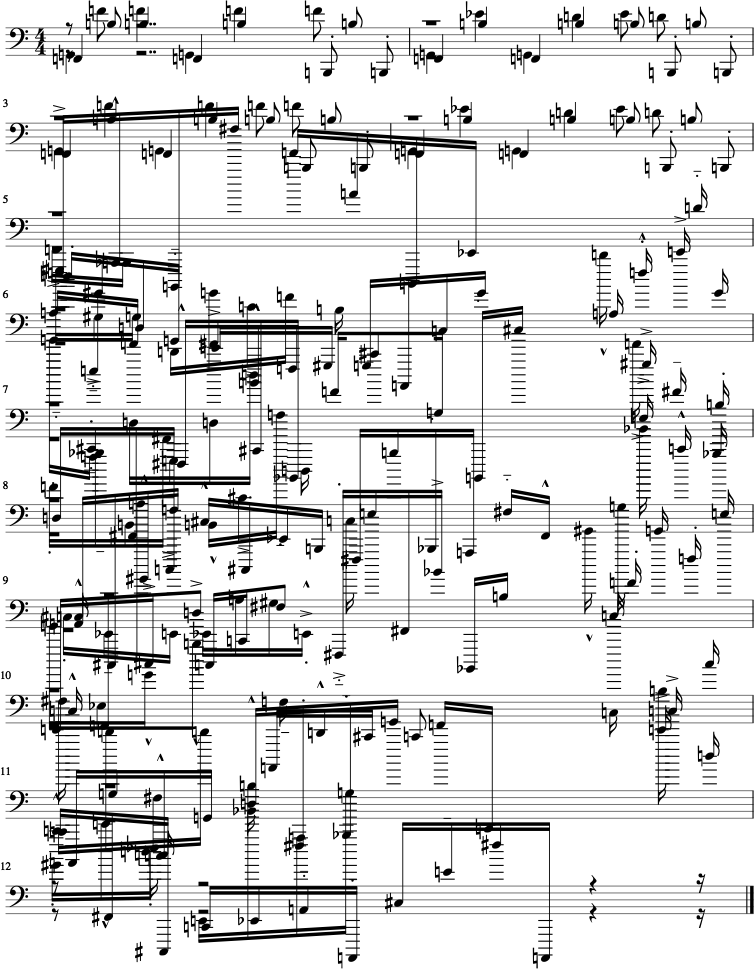

In [10]:
seed_file = 'data/ms_parts_1/ms_score_3047311.mxl'
seed_stream = m21.converter.parse(seed_file)
seed_state = model.data_manager.s.stream_to_statematrix(seed_stream)
seed_input = model.data_manager.f.note_state_matrix_to_input_form(seed_state)

length = 64 if len(seed_input) > 64 else len(seed_input)

generated_state = np.concatenate((seed_state[:length], model.generate_fun(128, 1, seed_input[:length])), axis=0)
generated_steam = model.data_manager.s.statematrix_to_stream(generated_state)
generated_steam.show()